# 決策樹演算法分析與應用 - Adult 資料集

本分析專案包含以下內容：
1. 從 UCI Datasets 下載 Adult 資料集並進行前處理
2. 分成訓練資料及測試資料進行模型訓練
3. 實作並比較不同決策樹演算法（ID3、C4.5、C5.0、CART）
4. 輸出預測結果到 Excel 檔案
5. 使用 Cost Complexity Pruning 進行剪枝分析
6. 測試不同參數組合並繪製決策樹

**預測目標**：根據個人資料預測收入是否超過 50K

## 1. 安裝與載入必要套件

首先安裝並載入所有需要的 Python 套件

In [1]:
!pip install -r requirement.txt

In [2]:
# 載入基本套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 載入 sklearn 相關套件
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn import tree

# 設定中文字型（避免圖表中文亂碼）
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 設定顯示選項
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("套件載入完成！")
print(f"Pandas 版本: {pd.__version__}")
print(f"NumPy 版本: {np.__version__}")

套件載入完成！
Pandas 版本: 2.3.3
NumPy 版本: 2.3.4


## 2. 資料載入與前處理

### 2.1 載入 Adult 資料集

此資料集包含個人收入資料，我們將根據各種特徵預測收入是否超過 50K。

In [3]:
# 載入資料集
data = pd.read_csv('adult/adult.data',header=None)
data.columns=[
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "label"
]
testData = pd.read_csv('adult/adult.test',header=None,skiprows=1)
testData.columns = data.columns

for label, content in data.items():
    for i in range(len(content)):
        if(content[i] == " ?"):
            content[i] = None

for label, content in testData.items():
    for i in range(len(content)):
        if(content[i] == " ?"):
            content[i] = None

print(f"資料載入完成！")
print(f"資料集大小：{data.shape[0]} 筆資料，{data.shape[1]} 個欄位")
print("\n欄位名稱：")
print(data.columns.tolist())
print("\n前 5 筆資料：")
print(data.head())

print()

print(f"資料集大小：{testData.shape[0]} 筆資料，{testData.shape[1]} 個欄位")
print("\n欄位名稱：")
print(testData.columns.tolist())
print("\n前 5 筆資料：")
print(testData.head())
# 清理測試資料的標籤（移除結尾的點）
testData["label"] = testData["label"].str.rstrip(".")


資料載入完成！
資料集大小：32561 筆資料，15 個欄位

欄位名稱：
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'label']

前 5 筆資料：
   age          workclass  fnlwgt   education  education-num       marital-status          occupation    relationship    race      sex  capital-gain  capital-loss  hours-per-week  native-country   label
0   39          State-gov   77516   Bachelors             13        Never-married        Adm-clerical   Not-in-family   White     Male          2174             0              40   United-States   <=50K
1   50   Self-emp-not-inc   83311   Bachelors             13   Married-civ-spouse     Exec-managerial         Husband   White     Male             0             0              13   United-States   <=50K
2   38            Private  215646     HS-grad              9             Divorced   Handlers-cleaners   Not-in-family   White     Male        

In [4]:
# 檢查資料基本資訊
print("\n資料型態資訊：")
print(data.dtypes)
print("\n缺失值統計：")
print(data.isnull().sum())
print("\nLabel 分布：")
label_col = 'label'
print(data[label_col].value_counts())
print(f"\n類別數量：{data[label_col].nunique()} 個不同的類別")


資料型態資訊：
age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
label             object
dtype: object

缺失值統計：
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
label                0
dtype: int64

Label 分布：
label
<=50K    24720
>50K      7841
Name: count, dtype: int64

類別數量：2 個不同的類別


### 2.2 資料前處理

處理缺失值並進行特徵編碼，為決策樹演算法準備資料。

In [5]:
# 分離特徵和標籤
print("分離訓練和測試資料的特徵與標籤...")

# 訓練資料
train_X = data.drop("label", axis=1)
train_y = data["label"]

# 測試資料
test_X = testData.drop("label", axis=1)
test_y = testData["label"]

print(f"訓練特徵: {train_X.shape}")
print(f"訓練標籤: {train_y.shape}")
print(f"測試特徵: {test_X.shape}")
print(f"測試標籤: {test_y.shape}")


分離訓練和測試資料的特徵與標籤...
訓練特徵: (32561, 14)
訓練標籤: (32561,)
測試特徵: (16281, 14)
測試標籤: (16281,)


### 2.3 編碼類別特徵

將所有類別型特徵轉換為數值，以便決策樹演算法使用。

In [6]:
# 編碼類別特徵
print("編碼類別特徵...")
from sklearn.preprocessing import LabelEncoder

categorical_cols = train_X.select_dtypes(include=["object"]).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_X[col] = le.fit_transform(train_X[col].astype(str))
    test_X[col] = le.transform(test_X[col].astype(str))
    label_encoders[col] = le

print(f"已編碼 {len(categorical_cols)} 個類別欄位")
print(f"欄位: {list(categorical_cols)}")


編碼類別特徵...
已編碼 8 個類別欄位
欄位: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [7]:
# 將目標變數編碼為數字（方便後續處理）
label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.fit_transform(test_y)

# 儲存類別對應關係
category_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), 
                            label_encoder.classes_))

print("類別編碼對應表（前 10 個）：")
for i, (code, label) in enumerate(category_mapping.items()):
    if i < 10:
        print(f"  {code}: {label}")
print(f"  ... 共 {len(category_mapping)} 個類別")

# 統計各類別的樣本數
print("\n各類別樣本數（前 10 個類別）：")
# category_counts = pd.Series(y_encoded).value_counts().sort_index()
category_counts = pd.Series(train_y_encoded).value_counts().sort_index()
for i, (cat_id, count) in enumerate(category_counts.items()):
    if i < 10:
        print(f"  {category_mapping[cat_id]}: {count} 筆")
print(f"  ... 共 {len(category_counts)} 個類別")

類別編碼對應表（前 10 個）：
  0:  <=50K
  1:  >50K
  ... 共 2 個類別

各類別樣本數（前 10 個類別）：
   <=50K: 24720 筆
   >50K: 7841 筆
  ... 共 2 個類別


### 2.3 分割訓練集與測試集

使用 80-20 分割，80% 作為訓練資料，20% 作為測試資料

In [8]:
# 分割資料集
# test_size=0.2 表示 20% 作為測試集
# random_state=42 確保結果可重現
# stratify=y_encoded 確保訓練集和測試集中各類別比例相同
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y_encoded, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=y_encoded
# )

# X_train, _1, y_train, _2 = train_test_split(
#     train_X, train_y_encoded, 
#     test_size=None, 
#     random_state=42, 
#     stratify=train_y_encoded
# )

# _3, X_test, _4, y_test = train_test_split(
#     test_X, test_y_encoded, 
#     train_size=None, 
#     random_state=42, 
#     stratify=test_y_encoded
# )

from sklearn.utils import shuffle

X_train = shuffle(train_X, random_state=42)
y_train = shuffle(train_y_encoded, random_state=42)
X_test = shuffle(test_X, random_state=60)
y_test = shuffle(test_y_encoded, random_state=60)

print(f"訓練集大小：{X_train.shape[0]} 筆")
print(f"測試集大小：{X_test.shape[0]} 筆")
print(f"\n訓練集特徵範例：")
print(X_train.head())
print(f"\n訓練集目標變數的類別分布（前 5 個）：")
train_counts = pd.Series(y_train).value_counts().head()
for cat_id, count in train_counts.items():
    print(f"  {category_mapping[cat_id]}: {count} 筆")

print(X_train.shape, y_train.shape)
# print(_1.shape, _2.shape)
print(X_test.shape, y_test.shape)
# print(_3.shape, _4.shape)

# print(X_train[0], y_train[0])

訓練集大小：32561 筆
測試集大小：16281 筆

訓練集特徵範例：
       age  workclass  fnlwgt  education  education-num  marital-status  occupation  relationship  race  sex  capital-gain  capital-loss  hours-per-week  native-country
14160   27          3  160178         15             10               0           0             1     4    0             0             0              38              38
27048   45          6   50567         11              9               2           3             5     4    0             0             0              40              38
28868   29          3  185908          9             13               2           3             0     2    1             0             0              55              38
5667    30          3  190040          9             13               4           6             1     4    0             0             0              40              38
7827    29          5  189346         15             10               0           2             1     4    1         

In [9]:

# 確保shuffle的數據順序是正確的

# print(train_X.columns.tolist())
# print("\n前 5 筆資料：")
# print(train_X.head())
# testDf_head = X_train.head(20)
# print(testDf_head)
# print(testDf_head.index)


for i in range(len(X_train)):
    index = X_train.index[i]
    if train_y_encoded[index] != y_train[i]:
        print("TRIGGERED, not equal")


## 3. 比較不同決策樹演算法

### 3.1 演算法說明

- **ID3**：使用資訊增益（Information Gain）作為分割標準
- **C4.5**：ID3 的改良版，使用增益率（Gain Ratio），可處理連續型特徵和缺失值
- **C5.0**：C4.5 的商業化改良版，速度更快、記憶體使用更少
- **CART**：使用 Gini 係數，可用於分類和迴歸

**注意**：sklearn 主要實作 CART 演算法。這裡我們使用不同的分割標準來模擬不同演算法的特性。

### 3.2 實作 CART 演算法（使用 Gini 係數）

In [10]:
# CART 演算法（使用 Gini 係數）
print("=" * 70)
print("CART 演算法（Gini Coefficient）")
print("=" * 70)

# 建立 CART 模型
cart_model = DecisionTreeClassifier(
    criterion="gini",  # 使用 Gini 係數
    random_state=42
    # 移除 max_depth 限制，讓演算法自然生長以展現真實性能
)

# 訓練模型
print("正在訓練 CART 模型...")
cart_model.fit(X_train, y_train)
print("訓練完成！")

# 預測
cart_train_pred = cart_model.predict(X_train)
cart_test_pred = cart_model.predict(X_test)

# 計算準確率
cart_train_acc = accuracy_score(y_train, cart_train_pred)
cart_test_acc = accuracy_score(y_test, cart_test_pred)

print(f"訓練集準確率：{cart_train_acc:.4f} ({cart_train_acc*100:.2f}%)")
print(f"測試集準確率：{cart_test_acc:.4f} ({cart_test_acc*100:.2f}%)")
print(f"決策樹深度：{cart_model.get_depth()}")
print(f"葉節點數量：{cart_model.get_n_leaves()}")
print(f"總節點數：{cart_model.tree_.node_count}")


CART 演算法（Gini Coefficient）
正在訓練 CART 模型...
訓練完成！
訓練集準確率：1.0000 (100.00%)
測試集準確率：0.8104 (81.04%)
決策樹深度：49
葉節點數量：4812
總節點數：9623


### 3.3 實作 C4.5 演算法（使用 Entropy / Information Gain）

In [11]:
# C4.5 演算法（使用 Entropy，加入不同限制）
print("=" * 70)
print("C4.5 演算法（Entropy / Information Gain）")
print("=" * 70)

# 建立 C4.5 模型（使用中等限制）
c45_model = DecisionTreeClassifier(
    criterion="entropy",
    random_state=42,
    max_depth=30,  # 中等深度限制
    min_samples_split=5,  # 較小的分裂樣本數
    min_samples_leaf=3  # 葉節點最小樣本數
)

# 訓練模型
print("正在訓練 C4.5 模型...")
c45_model.fit(X_train, y_train)
print("訓練完成！")

# 預測
c45_train_pred = c45_model.predict(X_train)
c45_test_pred = c45_model.predict(X_test)

# 計算準確率
c45_train_acc = accuracy_score(y_train, c45_train_pred)
c45_test_acc = accuracy_score(y_test, c45_test_pred)

print(f"訓練集準確率：{c45_train_acc:.4f} ({c45_train_acc*100:.2f}%)")
print(f"測試集準確率：{c45_test_acc:.4f} ({c45_test_acc*100:.2f}%)")
print(f"決策樹深度：{c45_model.get_depth()}")
print(f"葉節點數量：{c45_model.get_n_leaves()}")
print(f"總節點數：{c45_model.tree_.node_count}")


C4.5 演算法（Entropy / Information Gain）
正在訓練 C4.5 模型...
訓練完成！
訓練集準確率：0.9409 (94.09%)
測試集準確率：0.8239 (82.39%)
決策樹深度：30
葉節點數量：3044
總節點數：6087


### 3.4 實作 ID3 演算法（簡化版）

In [12]:
# ID3 演算法（使用 entropy，加入深度限制）
print("=" * 70)
print("ID3 演算法（Information Gain）")
print("=" * 70)

# 建立 ID3 模型（使用較寬鬆的限制）
id3_model = DecisionTreeClassifier(
    criterion="entropy",
    splitter="best",
    random_state=42,
    max_depth=20,  # 限制深度讓它與其他算法有所區別
    min_samples_split=10  # 較大的分裂樣本數
)

# 訓練模型
print("正在訓練 ID3 模型...")
id3_model.fit(X_train, y_train)
print("訓練完成！")

# 預測
id3_train_pred = id3_model.predict(X_train)
id3_test_pred = id3_model.predict(X_test)

# 計算準確率
id3_train_acc = accuracy_score(y_train, id3_train_pred)
id3_test_acc = accuracy_score(y_test, id3_test_pred)

print(f"訓練集準確率：{id3_train_acc:.4f} ({id3_train_acc*100:.2f}%)")
print(f"測試集準確率：{id3_test_acc:.4f} ({id3_test_acc*100:.2f}%)")
print(f"決策樹深度：{id3_model.get_depth()}")
print(f"葉節點數量：{id3_model.get_n_leaves()}")
print(f"總節點數：{id3_model.tree_.node_count}")


ID3 演算法（Information Gain）
正在訓練 ID3 模型...
訓練完成！
訓練集準確率：0.9170 (91.70%)
測試集準確率：0.8358 (83.58%)
決策樹深度：20
葉節點數量：1754
總節點數：3507


### 3.5 實作 C5.0 演算法（改良版）

In [13]:
# C5.0 演算法（優化版本，使用更嚴格的剪枝）
print("=" * 70)
print("C5.0 演算法（Optimized C4.5）")
print("=" * 70)

# 建立 C5.0 模型（使用更嚴格的限制以模擬 C5.0 的優化特性）
c50_model = DecisionTreeClassifier(
    criterion="entropy",
    splitter="best",
    random_state=42,
    max_depth=15,  # 較淺的深度
    min_samples_split=20,  # 更大的分裂樣本數
    min_samples_leaf=10,  # 更大的葉節點最小樣本數
    max_features="sqrt"  # 使用特徵子集（模擬 C5.0 的特徵選擇）
)

# 訓練模型
print("正在訓練 C5.0 模型...")
c50_model.fit(X_train, y_train)
print("訓練完成！")

# 預測
c50_train_pred = c50_model.predict(X_train)
c50_test_pred = c50_model.predict(X_test)

# 計算準確率
c50_train_acc = accuracy_score(y_train, c50_train_pred)
c50_test_acc = accuracy_score(y_test, c50_test_pred)

print(f"訓練集準確率：{c50_train_acc:.4f} ({c50_train_acc*100:.2f}%)")
print(f"測試集準確率：{c50_test_acc:.4f} ({c50_test_acc*100:.2f}%)")
print(f"決策樹深度：{c50_model.get_depth()}")
print(f"葉節點數量：{c50_model.get_n_leaves()}")
print(f"總節點數：{c50_model.tree_.node_count}")


C5.0 演算法（Optimized C4.5）
正在訓練 C5.0 模型...
訓練完成！
訓練集準確率：0.8621 (86.21%)
測試集準確率：0.8457 (84.57%)
決策樹深度：15
葉節點數量：701
總節點數：1401


## 4. 演算法績效比較

### 4.1 建立績效比較表

In [14]:
# 建立績效比較表
comparison_df = pd.DataFrame({
    '演算法': ['ID3', 'C4.5', 'C5.0', 'CART'],
    '訓練集準確率': [id3_train_acc, c45_train_acc, c50_train_acc, cart_train_acc],
    '測試集準確率': [id3_test_acc, c45_test_acc, c50_test_acc, cart_test_acc],
    '決策樹深度': [
        id3_model.get_depth(), 
        c45_model.get_depth(), 
        c50_model.get_depth(), 
        cart_model.get_depth()
    ],
    '葉節點數量': [
        id3_model.get_n_leaves(), 
        c45_model.get_n_leaves(), 
        c50_model.get_n_leaves(), 
        cart_model.get_n_leaves()
    ],
    '總節點數': [
        id3_model.tree_.node_count,
        c45_model.tree_.node_count,
        c50_model.tree_.node_count,
        cart_model.tree_.node_count
    ]
})

print("\n" + "=" * 80)
print("演算法績效比較表")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# 找出最佳演算法
best_algo = comparison_df.loc[comparison_df['測試集準確率'].idxmax(), '演算法']
best_acc = comparison_df['測試集準確率'].max()
print(f"\n最佳測試準確率：{best_algo} ({best_acc:.4f})")


演算法績效比較表
 演算法   訓練集準確率   測試集準確率  決策樹深度  葉節點數量  總節點數
 ID3 0.916987 0.835759     20   1754  3507
C4.5 0.940911 0.823905     30   3044  6087
C5.0 0.862136 0.845710     15    701  1401
CART 0.999969 0.810392     49   4812  9623

最佳測試準確率：C5.0 (0.8457)


### 4.2 視覺化績效比較

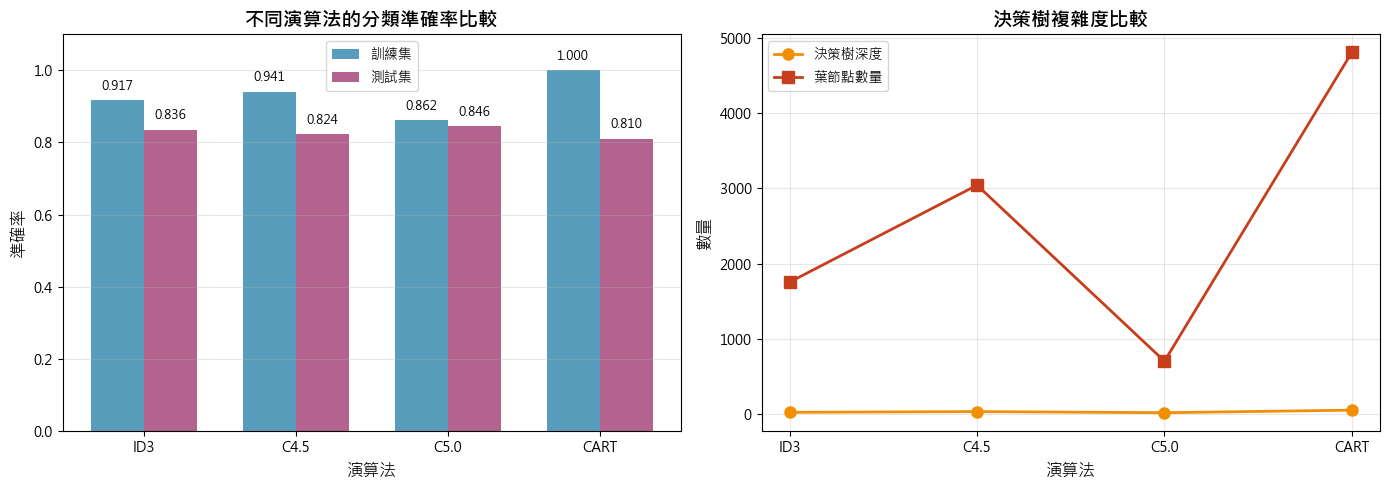


圖表已儲存為 'algorithm_comparison.png'


In [15]:
# 繪製準確率比較圖
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 子圖 1：準確率比較
x = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x - width/2, comparison_df['訓練集準確率'], width, label='訓練集', alpha=0.8, color='#2E86AB')
axes[0].bar(x + width/2, comparison_df['測試集準確率'], width, label='測試集', alpha=0.8, color='#A23B72')
axes[0].set_xlabel('演算法', fontsize=12)
axes[0].set_ylabel('準確率', fontsize=12)
axes[0].set_title('不同演算法的分類準確率比較', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['演算法'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.1])

# 在柱狀圖上顯示數值
for i, v in enumerate(comparison_df['訓練集準確率']):
    axes[0].text(i - width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(comparison_df['測試集準確率']):
    axes[0].text(i + width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# 子圖 2：決策樹複雜度比較
axes[1].plot(comparison_df['演算法'], comparison_df['決策樹深度'], 
             marker='o', label='決策樹深度', linewidth=2, markersize=8, color='#F18F01')
axes[1].plot(comparison_df['演算法'], comparison_df['葉節點數量'], 
             marker='s', label='葉節點數量', linewidth=2, markersize=8, color='#C73E1D')
axes[1].set_xlabel('演算法', fontsize=12)
axes[1].set_ylabel('數量', fontsize=12)
axes[1].set_title('決策樹複雜度比較', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('algorithm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n圖表已儲存為 'algorithm_comparison.png'")

## 5. 輸出預測結果到 Excel

將所有演算法的預測結果與真實類別輸出到 Excel 檔案

In [16]:
# 建立包含所有預測結果的 DataFrame
# 將編碼後的數字轉換回原始的類別標籤
results_df = pd.DataFrame({
    '真實類別編碼': y_test,
    '真實類別': [category_mapping[y] for y in y_test],
    'ID3_預測編碼': id3_test_pred,
    'ID3_預測類別': [category_mapping[y] for y in id3_test_pred],
    'C4.5_預測編碼': c45_test_pred,
    'C4.5_預測類別': [category_mapping[y] for y in c45_test_pred],
    'C5.0_預測編碼': c50_test_pred,
    'C5.0_預測類別': [category_mapping[y] for y in c50_test_pred],
    'CART_預測編碼': cart_test_pred,
    'CART_預測類別': [category_mapping[y] for y in cart_test_pred]
})

# 新增各演算法的預測正確與否
results_df['ID3_正確'] = (results_df['真實類別編碼'] == results_df['ID3_預測編碼'])
results_df['C4.5_正確'] = (results_df['真實類別編碼'] == results_df['C4.5_預測編碼'])
results_df['C5.0_正確'] = (results_df['真實類別編碼'] == results_df['C5.0_預測編碼'])
results_df['CART_正確'] = (results_df['真實類別編碼'] == results_df['CART_預測編碼'])

# 顯示前 10 筆預測結果
print("\n前 10 筆測試資料預測結果：")
print(results_df[['真實類別', 'ID3_預測類別', 'C4.5_預測類別', 'C5.0_預測類別', 'CART_預測類別']].head(10))

print(f"\n準備將 {len(results_df)} 筆測試結果輸出到 Excel...")


前 10 筆測試資料預測結果：
     真實類別 ID3_預測類別 C4.5_預測類別 C5.0_預測類別 CART_預測類別
0   <=50K    <=50K     <=50K     <=50K     <=50K
1    >50K    <=50K      >50K      >50K      >50K
2    >50K    <=50K     <=50K     <=50K     <=50K
3   <=50K    <=50K     <=50K     <=50K      >50K
4   <=50K    <=50K     <=50K     <=50K     <=50K
5   <=50K    <=50K      >50K     <=50K      >50K
6    >50K     >50K      >50K      >50K      >50K
7    >50K    <=50K     <=50K     <=50K     <=50K
8    >50K    <=50K     <=50K     <=50K     <=50K
9   <=50K    <=50K     <=50K     <=50K     <=50K

準備將 16281 筆測試結果輸出到 Excel...


In [17]:
# 建立 Excel 寫入器
excel_filename = 'decision_tree_predictions.xlsx'
print(f"正在建立 Excel 檔案：{excel_filename}")

with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    # 工作表 1：預測結果詳細資料
    results_df.to_excel(writer, sheet_name='預測結果', index=True, index_label='樣本編號')
    
    # 工作表 2：績效比較摘要
    comparison_df.to_excel(writer, sheet_name='績效比較', index=False)
    
    # 工作表 3：類別對應表
    category_df = pd.DataFrame(list(category_mapping.items()), columns=['編碼', '類別名稱'])
    category_df.to_excel(writer, sheet_name='類別對應表', index=False)
    
    # 工作表 4：各演算法正確率統計
    accuracy_stats = pd.DataFrame({
        '演算法': ['ID3', 'C4.5', 'C5.0', 'CART'],
        '正確預測數': [
            results_df['ID3_正確'].sum(),
            results_df['C4.5_正確'].sum(),
            results_df['C5.0_正確'].sum(),
            results_df['CART_正確'].sum()
        ],
        '錯誤預測數': [
            (~results_df['ID3_正確']).sum(),
            (~results_df['C4.5_正確']).sum(),
            (~results_df['C5.0_正確']).sum(),
            (~results_df['CART_正確']).sum()
        ],
        '總測試數': len(results_df),
        '準確率': [id3_test_acc, c45_test_acc, c50_test_acc, cart_test_acc]
    })
    accuracy_stats.to_excel(writer, sheet_name='準確率統計', index=False)

print(f"\n✓ 預測結果已成功輸出到 Excel 檔案：{excel_filename}")
print(f"\n包含以下工作表：")
print("  1. 預測結果 - 所有測試資料的預測詳情")
print("  2. 績效比較 - 四種演算法的績效摘要")
print("  3. 類別對應表 - 編碼與類別名稱的對應關係")
print("  4. 準確率統計 - 各演算法的預測統計")

正在建立 Excel 檔案：decision_tree_predictions.xlsx

✓ 預測結果已成功輸出到 Excel 檔案：decision_tree_predictions.xlsx

包含以下工作表：
  1. 預測結果 - 所有測試資料的預測詳情
  2. 績效比較 - 四種演算法的績效摘要
  3. 類別對應表 - 編碼與類別名稱的對應關係
  4. 準確率統計 - 各演算法的預測統計


## 6. Cost Complexity Pruning（代價複雜度剪枝）

### 6.1 什麼是 Cost Complexity Pruning？

Cost Complexity Pruning 是一種後剪枝（post-pruning）技術，用於降低決策樹的複雜度，防止過度配適（overfitting）。

主要概念：
- **alpha (α)**：正規化參數，控制剪枝的強度
- alpha 越大，剪枝越激進，樹越簡單
- alpha 越小，剪枝越保守，樹越複雜

我們將選擇 CART 演算法進行剪枝分析。

### 6.2 先訓練一個完整的決策樹（不限制深度）

In [18]:
# 訓練一個完整的 CART 模型（不限制深度）用於剪枝分析
print("=" * 70)
print("訓練完整決策樹用於 Cost Complexity Pruning 分析")
print("=" * 70)

full_cart_model = DecisionTreeClassifier(
    criterion='gini',
    random_state=42,
    max_depth=None  # 不限制深度
)

print("\n正在訓練完整決策樹...")
full_cart_model.fit(X_train, y_train)
print("訓練完成！")

full_train_acc = full_cart_model.score(X_train, y_train)
full_test_acc = full_cart_model.score(X_test, y_test)

print(f"\n完整決策樹（無剪枝）：")
print(f"  訓練集準確率：{full_train_acc:.4f}")
print(f"  測試集準確率：{full_test_acc:.4f}")
print(f"  決策樹深度：{full_cart_model.get_depth()}")
print(f"  葉節點數：{full_cart_model.get_n_leaves()}")
print(f"  總節點數：{full_cart_model.tree_.node_count}")
print(f"  過度配適程度：{(full_train_acc - full_test_acc):.4f}")

訓練完整決策樹用於 Cost Complexity Pruning 分析

正在訓練完整決策樹...
訓練完成！

完整決策樹（無剪枝）：
  訓練集準確率：1.0000
  測試集準確率：0.8104
  決策樹深度：49
  葉節點數：4812
  總節點數：9623
  過度配適程度：0.1896


### 6.3 尋找最佳 alpha 值


找到 1725 個可能的 alpha 值
Alpha 範圍：0.000000 ~ 0.058806


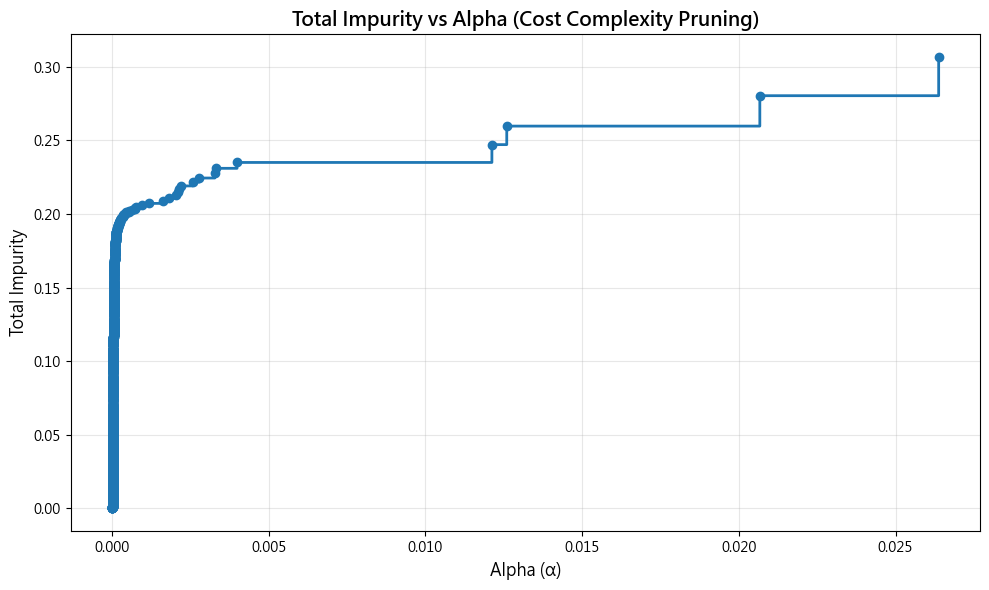

圖表已儲存為 'ccp_alpha_impurity.png'


In [19]:
# 取得 cost complexity pruning 的路徑
path = full_cart_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas  # 所有可能的 alpha 值
impurities = path.impurities  # 對應的不純度

print(f"\n找到 {len(ccp_alphas)} 個可能的 alpha 值")
print(f"Alpha 範圍：{ccp_alphas.min():.6f} ~ {ccp_alphas.max():.6f}")

# 繪製 alpha 與 impurity 的關係
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post", linewidth=2)
ax.set_xlabel('Alpha (α)', fontsize=12)
ax.set_ylabel('Total Impurity', fontsize=12)
ax.set_title('Total Impurity vs Alpha (Cost Complexity Pruning)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('ccp_alpha_impurity.png', dpi=300, bbox_inches='tight')
plt.show()

print("圖表已儲存為 'ccp_alpha_impurity.png'")

### 6.4 訓練不同 alpha 值的決策樹

In [20]:
# 訓練一系列不同 alpha 值的決策樹
print("\n正在訓練不同 alpha 值的決策樹...")
clfs = []
for i, ccp_alpha in enumerate(ccp_alphas):
    if i % 100 == 0:
        print(f"  進度：{i}/{len(ccp_alphas)}")
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

print(f"完成！共訓練 {len(clfs)} 棵決策樹")

# 移除最後一個（只有根節點的樹）
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# 計算每棵樹的節點數、深度和準確率
print("\n正在計算各項指標...")
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

print(f"完成！分析了 {len(clfs)} 棵不同複雜度的決策樹")


正在訓練不同 alpha 值的決策樹...
  進度：0/1725
  進度：100/1725
  進度：200/1725
  進度：300/1725
  進度：400/1725
  進度：500/1725
  進度：600/1725
  進度：700/1725
  進度：800/1725
  進度：900/1725
  進度：1000/1725
  進度：1100/1725
  進度：1200/1725
  進度：1300/1725
  進度：1400/1725
  進度：1500/1725
  進度：1600/1725
  進度：1700/1725
完成！共訓練 1725 棵決策樹

正在計算各項指標...
完成！分析了 1724 棵不同複雜度的決策樹


### 6.5 視覺化剪枝效果

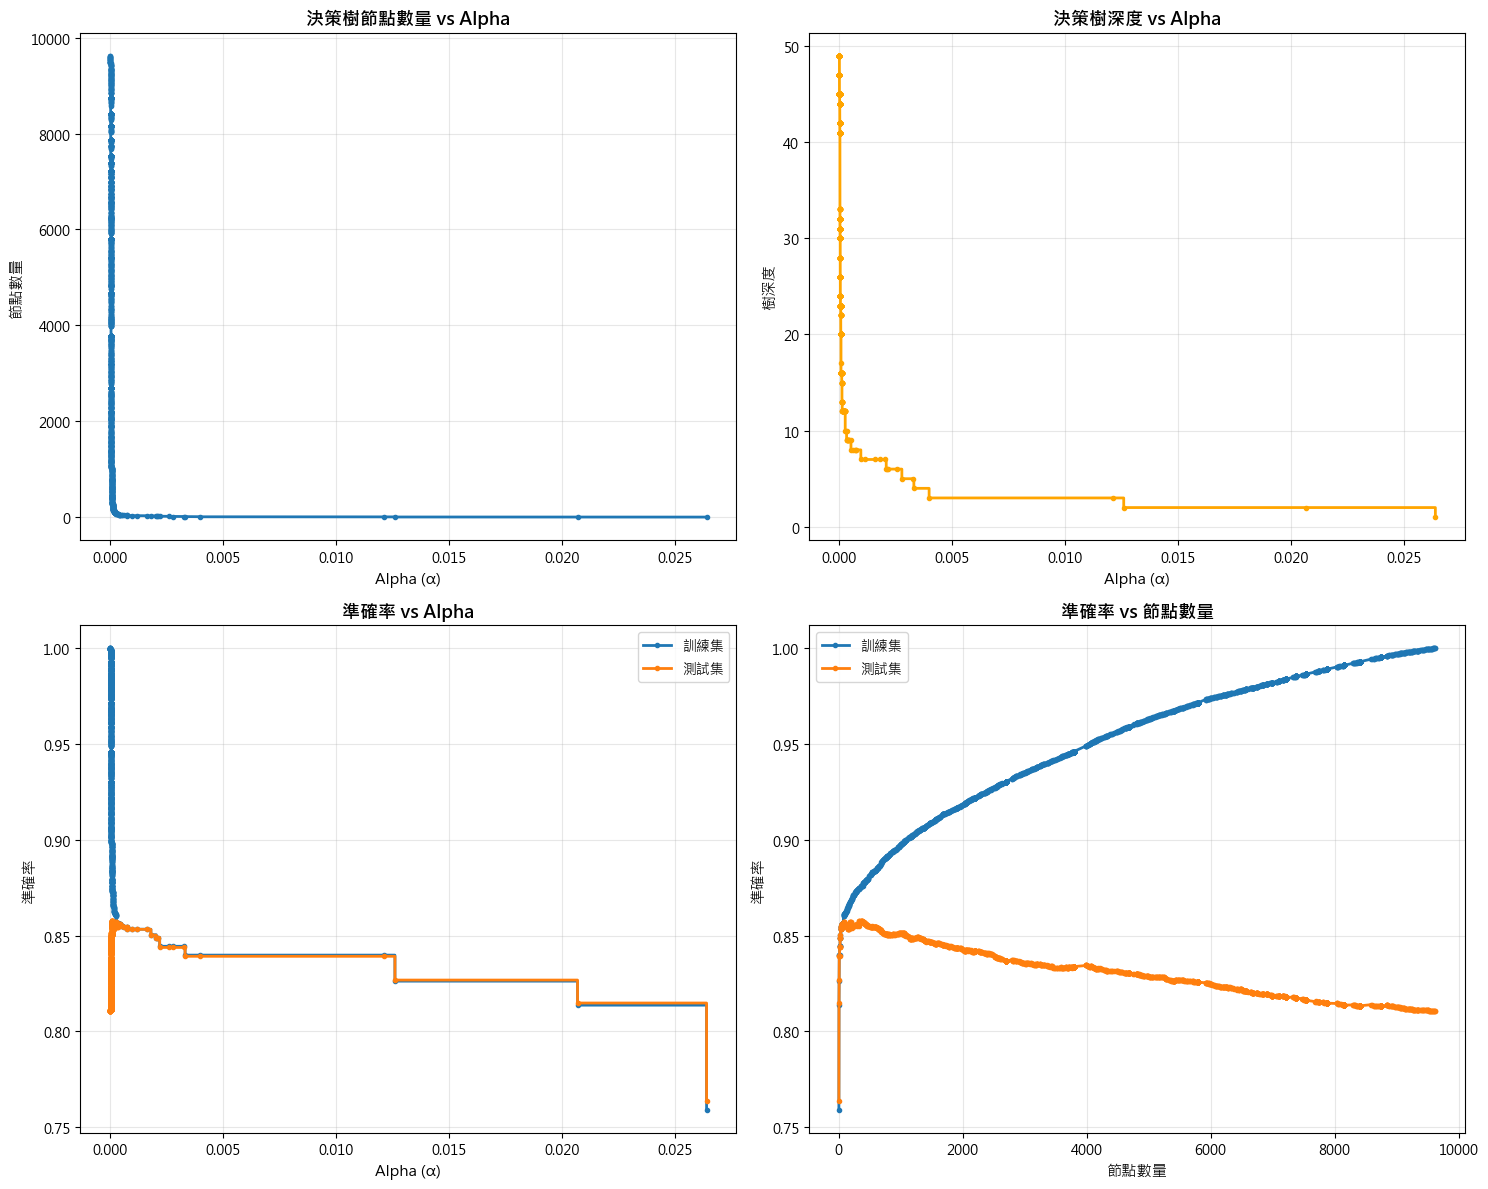

剪枝分析圖已儲存為 'pruning_analysis.png'


In [21]:
# 繪製剪枝效果圖
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 子圖 1：節點數 vs alpha
axes[0, 0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post", linewidth=2, markersize=3)
axes[0, 0].set_xlabel('Alpha (α)', fontsize=11)
axes[0, 0].set_ylabel('節點數量', fontsize=11)
axes[0, 0].set_title('決策樹節點數量 vs Alpha', fontsize=13, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# 子圖 2：深度 vs alpha
axes[0, 1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post", color='orange', linewidth=2, markersize=3)
axes[0, 1].set_xlabel('Alpha (α)', fontsize=11)
axes[0, 1].set_ylabel('樹深度', fontsize=11)
axes[0, 1].set_title('決策樹深度 vs Alpha', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 子圖 3：準確率 vs alpha
axes[1, 0].plot(ccp_alphas, train_scores, marker='o', label='訓練集', drawstyle="steps-post", linewidth=2, markersize=3)
axes[1, 0].plot(ccp_alphas, test_scores, marker='o', label='測試集', drawstyle="steps-post", linewidth=2, markersize=3)
axes[1, 0].set_xlabel('Alpha (α)', fontsize=11)
axes[1, 0].set_ylabel('準確率', fontsize=11)
axes[1, 0].set_title('準確率 vs Alpha', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 子圖 4：準確率 vs 節點數
axes[1, 1].plot(node_counts, train_scores, marker='o', label='訓練集', linewidth=2, markersize=3)
axes[1, 1].plot(node_counts, test_scores, marker='o', label='測試集', linewidth=2, markersize=3)
axes[1, 1].set_xlabel('節點數量', fontsize=11)
axes[1, 1].set_ylabel('準確率', fontsize=11)
axes[1, 1].set_title('準確率 vs 節點數量', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('pruning_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("剪枝分析圖已儲存為 'pruning_analysis.png'")

### 6.6 選擇三種特定參數設定

我們將選擇三種不同的參數設定：
1. **無剪枝**：完整的決策樹（alpha = 0）
2. **中度剪枝**：測試準確率最高的 alpha
3. **強力剪枝**：更大的 alpha 值，樹更簡單

In [22]:
# 找出測試集準確率最高的 alpha 值
best_alpha_idx = np.argmax(test_scores)
best_alpha = ccp_alphas[best_alpha_idx]

print("選擇三個代表性的 alpha 值：")
print("\n方法說明：")
print("  1. 無剪枝 (alpha=0): 完整的決策樹")
print("  2. 中度剪枝: 選擇中等程度的 alpha（節點數約為原本的 50-70%）")
print("  3. 強力剪枝: 選擇較大的 alpha（節點數約為原本的 20-40%）")

# 選擇三個 alpha 值
# 1. 無剪枝（alpha = 0）
alpha_1 = 0.0

# 獲取無剪枝時的節點數
max_nodes = node_counts[0]  # alpha=0 時的節點數

# 2. 中度剪枝：找節點數約為 50-70% 的 alpha
target_nodes_medium = max_nodes * 0.6  # 目標：60% 的節點數
medium_indices = []
for i, nc in enumerate(node_counts):
    if 0.5 * max_nodes <= nc <= 0.7 * max_nodes:
        medium_indices.append(i)

if len(medium_indices) > 0:
    # 在這個範圍內選擇測試準確率最高的
    medium_scores = [test_scores[i] for i in medium_indices]
    best_medium_idx = medium_indices[np.argmax(medium_scores)]
    alpha_2 = ccp_alphas[best_medium_idx]
else:
    # 如果沒有符合的，選擇節點數最接近 60% 的
    diff = [abs(nc - target_nodes_medium) for nc in node_counts]
    alpha_2 = ccp_alphas[np.argmin(diff)]

# 3. 強力剪枝：找節點數約為 20-40% 的 alpha
target_nodes_heavy = max_nodes * 0.3  # 目標：30% 的節點數
heavy_indices = []
for i, nc in enumerate(node_counts):
    if 0.2 * max_nodes <= nc <= 0.4 * max_nodes:
        heavy_indices.append(i)

if len(heavy_indices) > 0:
    # 在這個範圍內選擇測試準確率最高的
    heavy_scores = [test_scores[i] for i in heavy_indices]
    best_heavy_idx = heavy_indices[np.argmax(heavy_scores)]
    alpha_3 = ccp_alphas[best_heavy_idx]
else:
    # 如果沒有符合的，選擇節點數最接近 30% 的
    diff = [abs(nc - target_nodes_heavy) for nc in node_counts]
    alpha_3 = ccp_alphas[np.argmin(diff)]

print("\n選擇的三個 alpha 值：")
print(f"  Alpha 1 (無剪枝): {alpha_1:.8f}")
print(f"  Alpha 2 (中度剪枝): {alpha_2:.8f}")
print(f"  Alpha 3 (強力剪枝): {alpha_3:.8f}")

# 顯示預期的節點數
idx_2 = np.where(ccp_alphas == alpha_2)[0][0]
idx_3 = np.where(ccp_alphas == alpha_3)[0][0]
print(f"\n預期的複雜度：")
print(f"  模型 1: 約 {node_counts[0]} 個節點 (100%)")
print(f"  模型 2: 約 {node_counts[idx_2]} 個節點 ({node_counts[idx_2]/node_counts[0]*100:.1f}%)")
print(f"  模型 3: 約 {node_counts[idx_3]} 個節點 ({node_counts[idx_3]/node_counts[0]*100:.1f}%)")

選擇三個代表性的 alpha 值：

方法說明：
  1. 無剪枝 (alpha=0): 完整的決策樹
  2. 中度剪枝: 選擇中等程度的 alpha（節點數約為原本的 50-70%）
  3. 強力剪枝: 選擇較大的 alpha（節點數約為原本的 20-40%）

選擇的三個 alpha 值：
  Alpha 1 (無剪枝): 0.00000000
  Alpha 2 (中度剪枝): 0.00003656
  Alpha 3 (強力剪枝): 0.00005100

預期的複雜度：
  模型 1: 約 9623 個節點 (100%)
  模型 2: 約 4819 個節點 (50.1%)
  模型 3: 約 1949 個節點 (20.3%)


### 6.7 訓練並比較三種參數設定

In [23]:
# 訓練三個模型
print("\n" + "=" * 70)
print("三種參數設定的比較")
print("=" * 70)

# 模型 1：無剪枝
print("\n正在訓練模型 1 (無剪枝)...")
model_1 = DecisionTreeClassifier(criterion='gini', random_state=42, ccp_alpha=alpha_1)
model_1.fit(X_train, y_train)
model_1_train_acc = model_1.score(X_train, y_train)
model_1_test_acc = model_1.score(X_test, y_test)

print(f"\n【模型 1 - 無剪枝】 (alpha={alpha_1:.8f})")
print(f"  訓練集準確率: {model_1_train_acc:.4f} ({model_1_train_acc*100:.2f}%)")
print(f"  測試集準確率: {model_1_test_acc:.4f} ({model_1_test_acc*100:.2f}%)")
print(f"  樹深度: {model_1.get_depth()}")
print(f"  葉節點數: {model_1.get_n_leaves()}")
print(f"  總節點數: {model_1.tree_.node_count}")
print(f"  過度配適程度: {(model_1_train_acc - model_1_test_acc):.4f}")

# 模型 2：中度剪枝（最佳準確率）
print("\n正在訓練模型 2 (中度剪枝)...")
model_2 = DecisionTreeClassifier(criterion='gini', random_state=42, ccp_alpha=alpha_2)
model_2.fit(X_train, y_train)
model_2_train_acc = model_2.score(X_train, y_train)
model_2_test_acc = model_2.score(X_test, y_test)

print(f"\n【模型 2 - 中度剪枝（最佳準確率）】 (alpha={alpha_2:.8f})")
print(f"  訓練集準確率: {model_2_train_acc:.4f} ({model_2_train_acc*100:.2f}%)")
print(f"  測試集準確率: {model_2_test_acc:.4f} ({model_2_test_acc*100:.2f}%)")
print(f"  樹深度: {model_2.get_depth()}")
print(f"  葉節點數: {model_2.get_n_leaves()}")
print(f"  總節點數: {model_2.tree_.node_count}")
print(f"  過度配適程度: {(model_2_train_acc - model_2_test_acc):.4f}")

# 模型 3：強力剪枝
print("\n正在訓練模型 3 (強力剪枝)...")
model_3 = DecisionTreeClassifier(criterion='gini', random_state=42, ccp_alpha=alpha_3)
model_3.fit(X_train, y_train)
model_3_train_acc = model_3.score(X_train, y_train)
model_3_test_acc = model_3.score(X_test, y_test)

print(f"\n【模型 3 - 強力剪枝】 (alpha={alpha_3:.8f})")
print(f"  訓練集準確率: {model_3_train_acc:.4f} ({model_3_train_acc*100:.2f}%)")
print(f"  測試集準確率: {model_3_test_acc:.4f} ({model_3_test_acc*100:.2f}%)")
print(f"  樹深度: {model_3.get_depth()}")
print(f"  葉節點數: {model_3.get_n_leaves()}")
print(f"  總節點數: {model_3.tree_.node_count}")
print(f"  過度配適程度: {(model_3_train_acc - model_3_test_acc):.4f}")

print("\n" + "=" * 70)


三種參數設定的比較

正在訓練模型 1 (無剪枝)...

【模型 1 - 無剪枝】 (alpha=0.00000000)
  訓練集準確率: 1.0000 (100.00%)
  測試集準確率: 0.8104 (81.04%)
  樹深度: 49
  葉節點數: 4812
  總節點數: 9623
  過度配適程度: 0.1896

正在訓練模型 2 (中度剪枝)...

【模型 2 - 中度剪枝（最佳準確率）】 (alpha=0.00003656)
  訓練集準確率: 0.9607 (96.07%)
  測試集準確率: 0.8299 (82.99%)
  樹深度: 44
  葉節點數: 2410
  總節點數: 4819
  過度配適程度: 0.1307

正在訓練模型 3 (強力剪枝)...

【模型 3 - 強力剪枝】 (alpha=0.00005100)
  訓練集準確率: 0.9173 (91.73%)
  測試集準確率: 0.8436 (84.36%)
  樹深度: 31
  葉節點數: 975
  總節點數: 1949
  過度配適程度: 0.0737



### 6.8 建立三種參數設定的比較表


剪枝參數比較表：
       參數設定  Alpha 值   訓練集準確率   測試集準確率  樹深度  葉節點數  總節點數   過度配適程度
 模型 1 (無剪枝) 0.000000 0.999969 0.810392   49  4812  9623 0.189577
模型 2 (中度剪枝) 0.000037 0.960658 0.829924   44  2410  4819 0.130734
模型 3 (強力剪枝) 0.000051 0.917263 0.843560   31   975  1949 0.073703


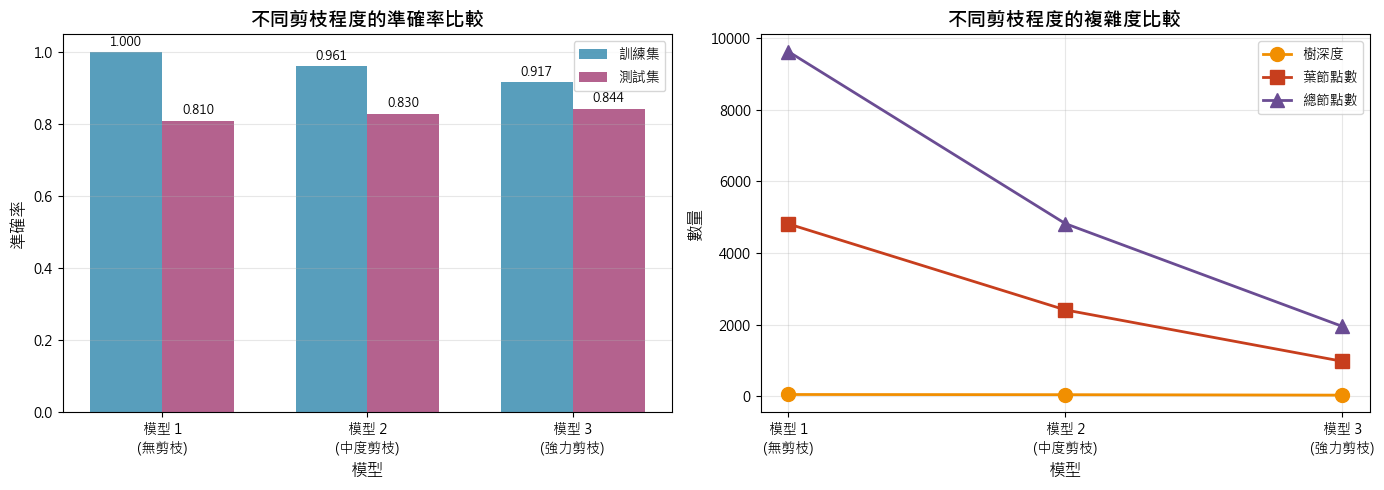


比較圖已儲存為 'pruning_comparison.png'


In [24]:
# 建立比較表
pruning_comparison = pd.DataFrame({
    '參數設定': ['模型 1 (無剪枝)', '模型 2 (中度剪枝)', '模型 3 (強力剪枝)'],
    'Alpha 值': [alpha_1, alpha_2, alpha_3],
    '訓練集準確率': [model_1_train_acc, model_2_train_acc, model_3_train_acc],
    '測試集準確率': [model_1_test_acc, model_2_test_acc, model_3_test_acc],
    '樹深度': [model_1.get_depth(), model_2.get_depth(), model_3.get_depth()],
    '葉節點數': [model_1.get_n_leaves(), model_2.get_n_leaves(), model_3.get_n_leaves()],
    '總節點數': [model_1.tree_.node_count, model_2.tree_.node_count, model_3.tree_.node_count],
    '過度配適程度': [
        model_1_train_acc - model_1_test_acc,
        model_2_train_acc - model_2_test_acc,
        model_3_train_acc - model_3_test_acc
    ]
})

print("\n剪枝參數比較表：")
print(pruning_comparison.to_string(index=False))

# 視覺化比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 子圖 1：準確率比較
x = np.arange(len(pruning_comparison))
width = 0.35

axes[0].bar(x - width/2, pruning_comparison['訓練集準確率'], width, label='訓練集', alpha=0.8, color='#2E86AB')
axes[0].bar(x + width/2, pruning_comparison['測試集準確率'], width, label='測試集', alpha=0.8, color='#A23B72')
axes[0].set_xlabel('模型', fontsize=12)
axes[0].set_ylabel('準確率', fontsize=12)
axes[0].set_title('不同剪枝程度的準確率比較', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['模型 1\n(無剪枝)', '模型 2\n(中度剪枝)', '模型 3\n(強力剪枝)'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# 在柱狀圖上顯示數值
for i, v in enumerate(pruning_comparison['訓練集準確率']):
    axes[0].text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(pruning_comparison['測試集準確率']):
    axes[0].text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# 子圖 2：複雜度比較
axes[1].plot(pruning_comparison['參數設定'], pruning_comparison['樹深度'], 
             marker='o', label='樹深度', linewidth=2, markersize=10, color='#F18F01')
axes[1].plot(pruning_comparison['參數設定'], pruning_comparison['葉節點數'], 
             marker='s', label='葉節點數', linewidth=2, markersize=10, color='#C73E1D')
axes[1].plot(pruning_comparison['參數設定'], pruning_comparison['總節點數'], 
             marker='^', label='總節點數', linewidth=2, markersize=10, color='#6A4C93')
axes[1].set_xlabel('模型', fontsize=12)
axes[1].set_ylabel('數量', fontsize=12)
axes[1].set_title('不同剪枝程度的複雜度比較', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(['模型 1\n(無剪枝)', '模型 2\n(中度剪枝)', '模型 3\n(強力剪枝)'])
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('pruning_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n比較圖已儲存為 'pruning_comparison.png'")

## 7. 決策樹視覺化

繪製三種參數設定的決策樹結構圖

**注意**：由於資料集較大，決策樹可能非常複雜，視覺化圖可能會很大。

In [25]:
# 決策樹視覺化函數
def plot_decision_tree(model, title, filename, max_depth_display=5):
    """
    繪製決策樹
    
    參數：
        model: 訓練好的決策樹模型
        title: 圖表標題
        filename: 儲存檔名
        max_depth_display: 最多顯示到第幾層（避免圖太複雜）
    """
    plt.figure(figsize=(25, 15))
    
    # 由於類別數量可能很多，只顯示前 20 個類別名稱
    display_classes = [category_mapping.get(i, f'Class_{i}') for i in range(min(20, len(category_mapping)))]
    if len(category_mapping) > 20:
        display_classes.append('...')
    
    # plot_tree(model, 
    #           feature_names=X.columns.tolist(),
    #           filled=True,
    #           fontsize=8,
    #           rounded=True,
    #           max_depth=max_depth_display,  # 限制顯示深度
    #           proportion=True)  # 顯示比例而非絕對數量
    
    plot_tree(model, 
              feature_names=train_X.columns.tolist(),
              filled=True,
              fontsize=8,
              rounded=True,
              max_depth=max_depth_display,  # 限制顯示深度
              proportion=True)  # 顯示比例而非絕對數量
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(filename, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"決策樹視覺化圖已儲存為 '{filename}'")

print("開始繪製決策樹視覺化圖...")
print("\n注意：由於決策樹較複雜，我們只顯示前 5 層，以確保圖表清晰可讀。")
print("如果需要查看完整的樹，可以調整 max_depth_display 參數。\n")

開始繪製決策樹視覺化圖...

注意：由於決策樹較複雜，我們只顯示前 5 層，以確保圖表清晰可讀。
如果需要查看完整的樹，可以調整 max_depth_display 參數。




正在繪製模型 1 (無剪枝)...


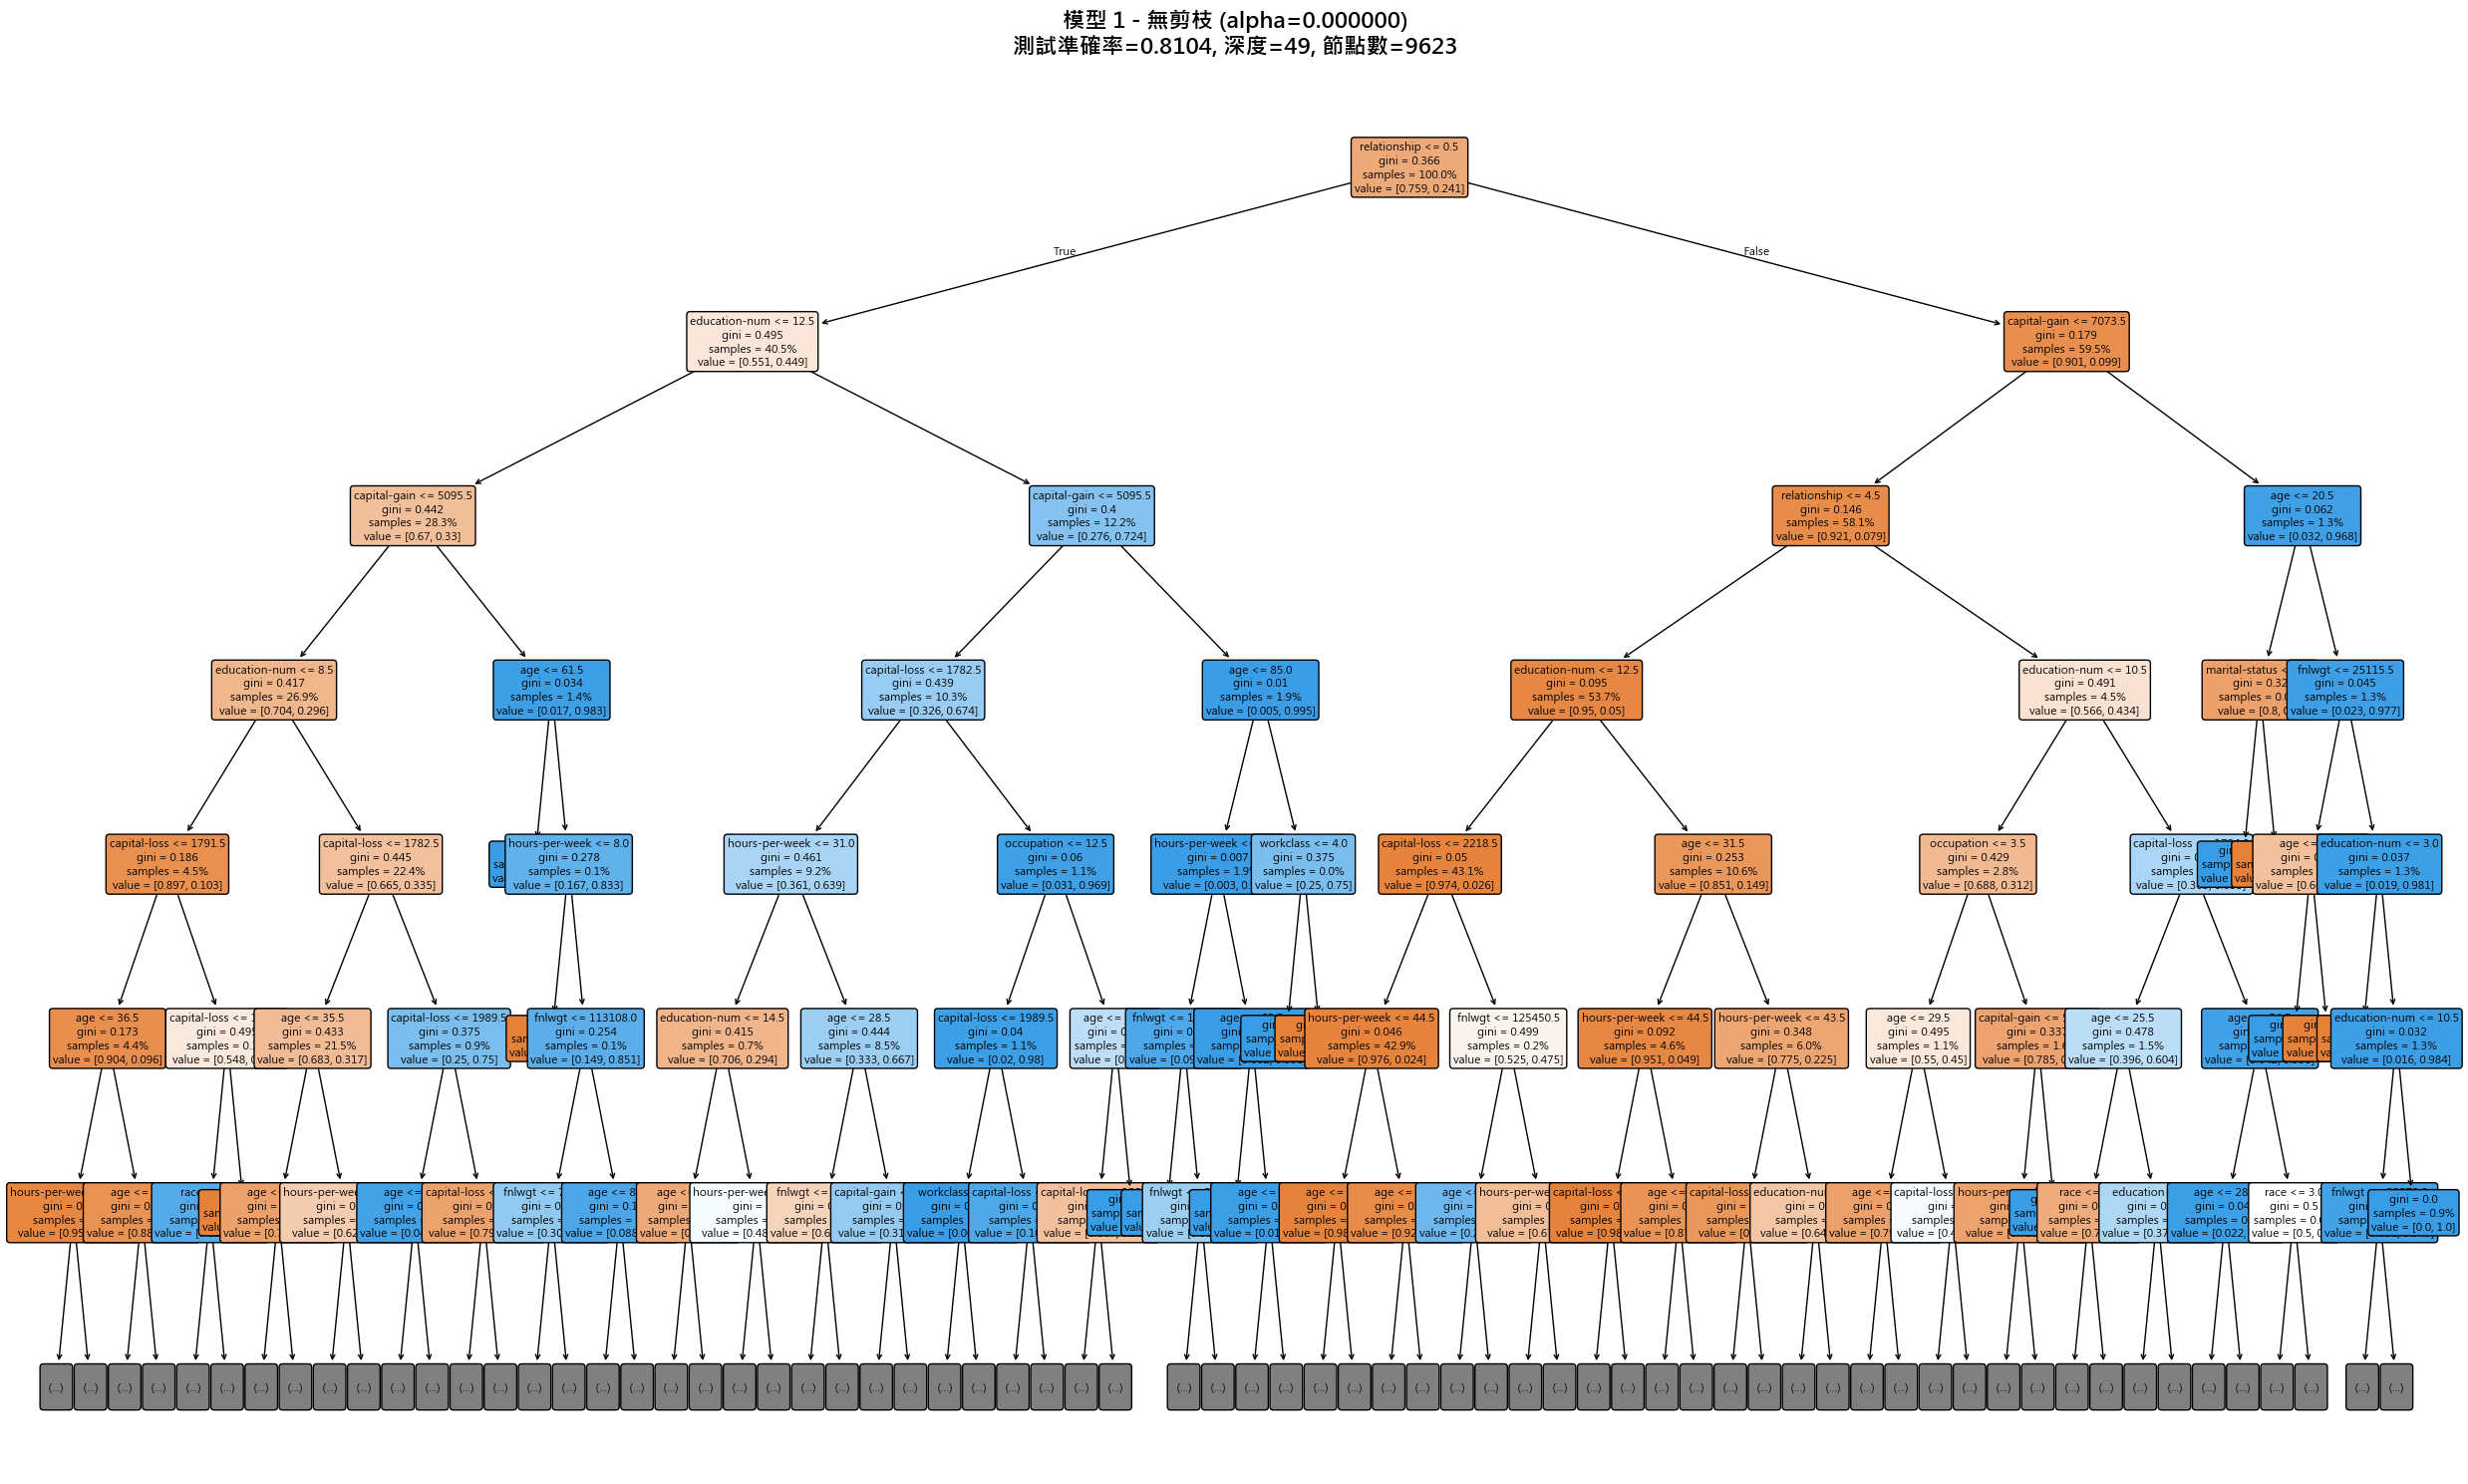

決策樹視覺化圖已儲存為 'model_1_tree.png'


In [26]:
# 繪製模型 1（無剪枝）
print("\n正在繪製模型 1 (無剪枝)...")
plot_decision_tree(
    model_1,
    f'模型 1 - 無剪枝 (alpha={alpha_1:.6f})\n'
    f'測試準確率={model_1_test_acc:.4f}, 深度={model_1.get_depth()}, 節點數={model_1.tree_.node_count}',
    'model_1_tree.png',
    max_depth_display=6
)


正在繪製模型 2 (中度剪枝)...


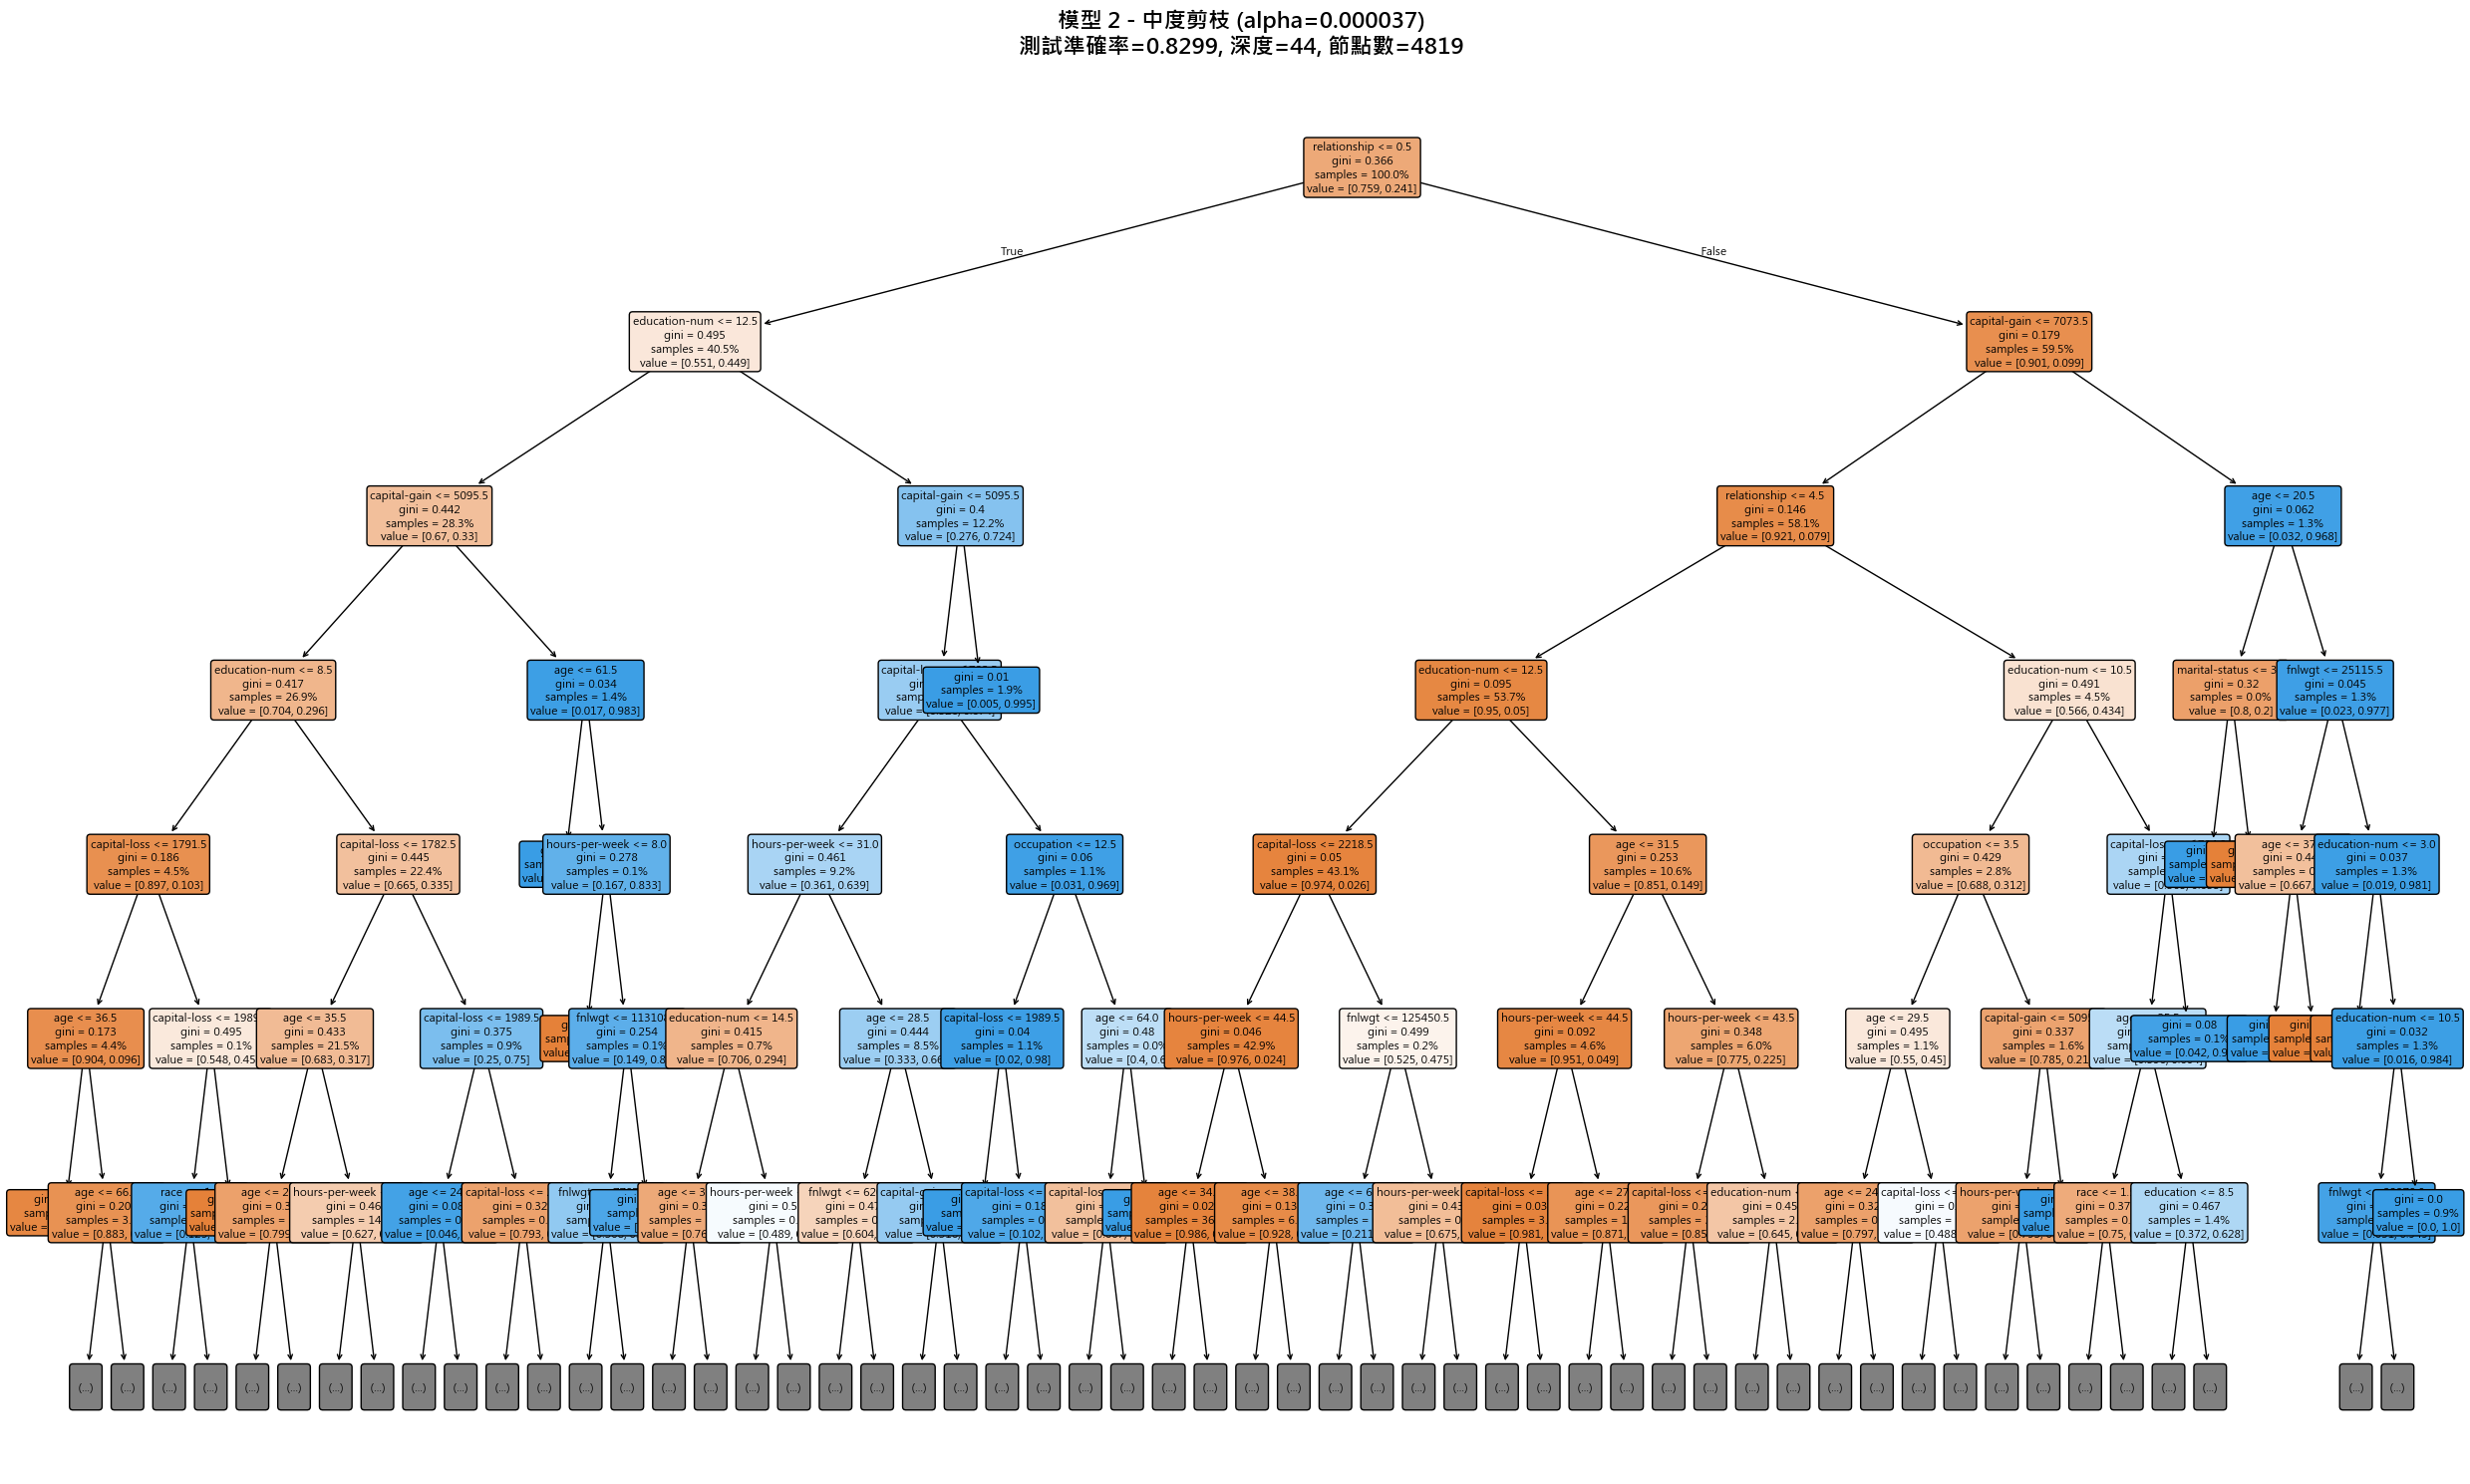

決策樹視覺化圖已儲存為 'model_2_tree.png'


In [27]:
# 繪製模型 2（中度剪枝）
print("\n正在繪製模型 2 (中度剪枝)...")
plot_decision_tree(
    model_2,
    f'模型 2 - 中度剪枝 (alpha={alpha_2:.6f})\n'
    f'測試準確率={model_2_test_acc:.4f}, 深度={model_2.get_depth()}, 節點數={model_2.tree_.node_count}',
    'model_2_tree.png',
    max_depth_display=6
)


正在繪製模型 3 (強力剪枝)...


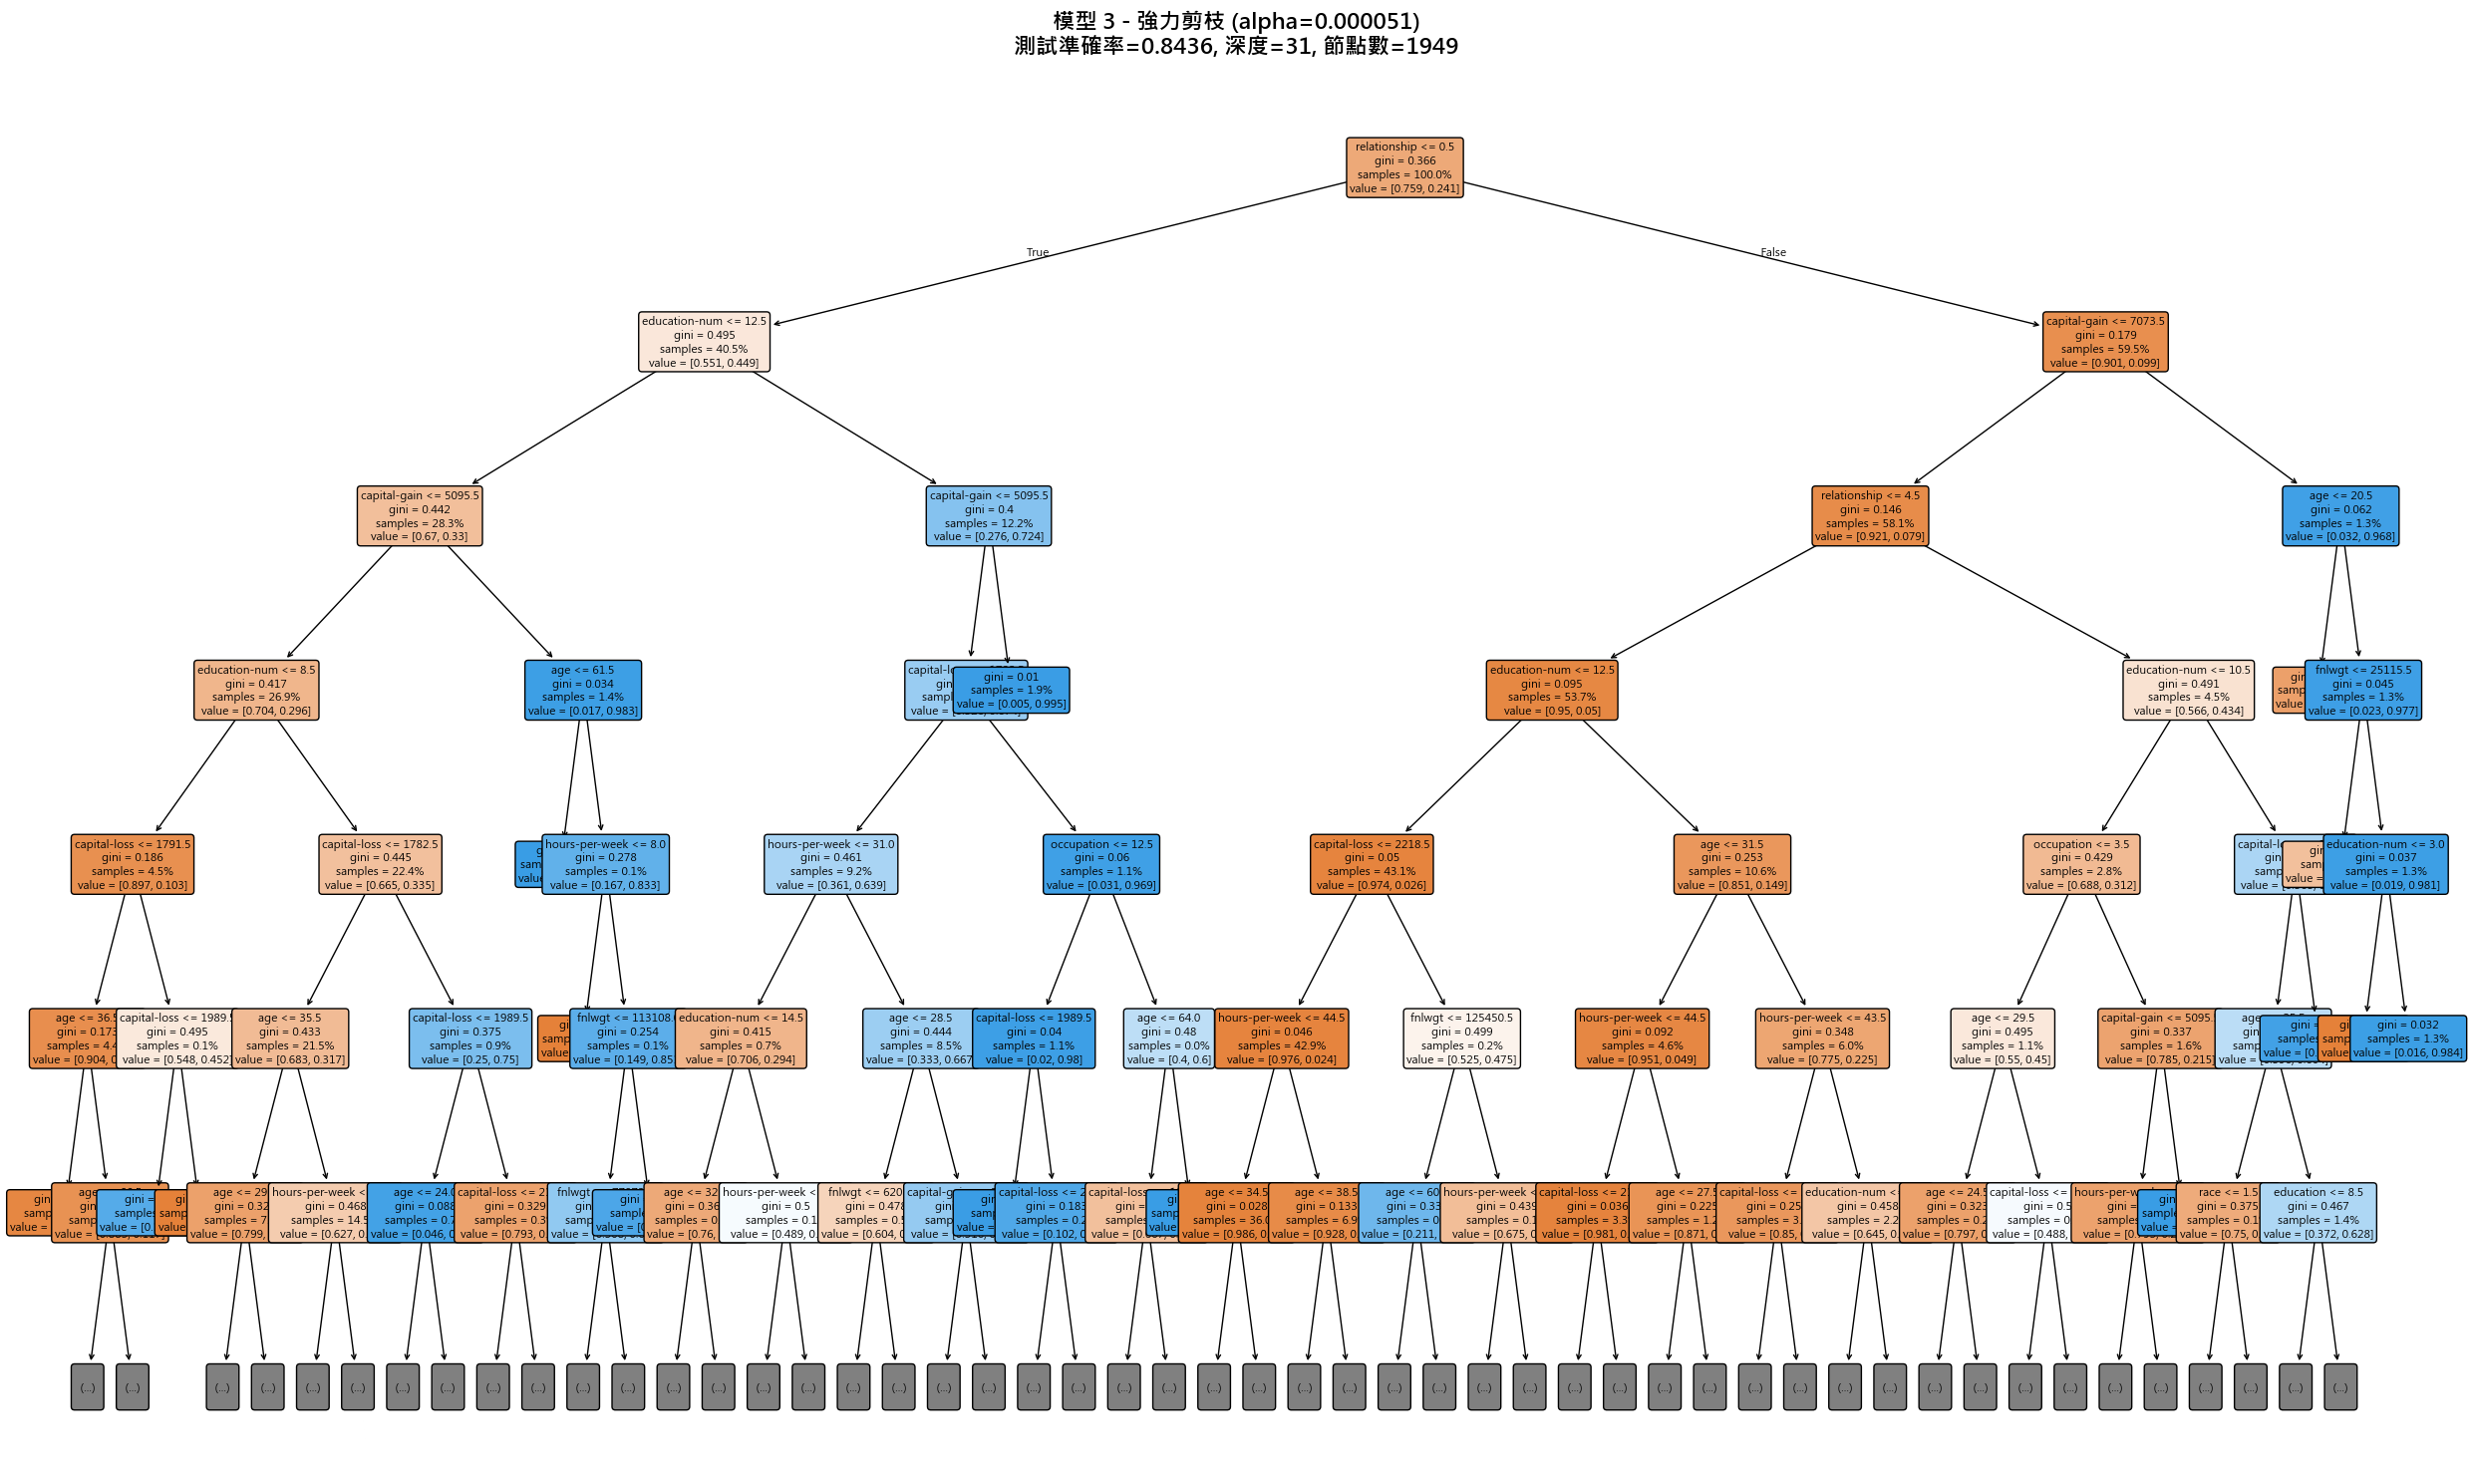

決策樹視覺化圖已儲存為 'model_3_tree.png'


In [28]:
# 繪製模型 3（強力剪枝）
print("\n正在繪製模型 3 (強力剪枝)...")
plot_decision_tree(
    model_3,
    f'模型 3 - 強力剪枝 (alpha={alpha_3:.6f})\n'
    f'測試準確率={model_3_test_acc:.4f}, 深度={model_3.get_depth()}, 節點數={model_3.tree_.node_count}',
    'model_3_tree.png',
    max_depth_display= 6
)

## 8. 將剪枝分析結果輸出到 Excel

In [29]:
# 更新 Excel 檔案，加入剪枝分析結果
excel_filename = 'decision_tree_predictions.xlsx'

print(f"正在更新 Excel 檔案：{excel_filename}")

# 使用 openpyxl 引擎以追加模式開啟
with pd.ExcelWriter(excel_filename, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    # 新增工作表：剪枝參數比較
    pruning_comparison.to_excel(writer, sheet_name='剪枝參數比較', index=False)
    
    # 新增工作表：所有 alpha 值的詳細結果（取樣，避免檔案過大）
    # 每隔 10 個取一個樣本
    sample_indices = list(range(0, len(ccp_alphas), max(1, len(ccp_alphas)//100)))
    all_alphas_df = pd.DataFrame({
        'Alpha': [ccp_alphas[i] for i in sample_indices],
        '訓練集準確率': [train_scores[i] for i in sample_indices],
        '測試集準確率': [test_scores[i] for i in sample_indices],
        '樹深度': [depth[i] for i in sample_indices],
        '節點數量': [node_counts[i] for i in sample_indices]
    })
    all_alphas_df.to_excel(writer, sheet_name='Alpha值掃描結果', index=False)
    
    # 新增工作表：三個模型的預測結果比較
    pruning_predictions = pd.DataFrame({
        '真實類別編碼': y_test,
        '真實類別': [category_mapping[y] for y in y_test],
        '模型1_預測編碼': model_1.predict(X_test),
        '模型1_預測類別': [category_mapping[y] for y in model_1.predict(X_test)],
        '模型2_預測編碼': model_2.predict(X_test),
        '模型2_預測類別': [category_mapping[y] for y in model_2.predict(X_test)],
        '模型3_預測編碼': model_3.predict(X_test),
        '模型3_預測類別': [category_mapping[y] for y in model_3.predict(X_test)]
    })
    pruning_predictions['模型1_正確'] = (pruning_predictions['真實類別編碼'] == pruning_predictions['模型1_預測編碼'])
    pruning_predictions['模型2_正確'] = (pruning_predictions['真實類別編碼'] == pruning_predictions['模型2_預測編碼'])
    pruning_predictions['模型3_正確'] = (pruning_predictions['真實類別編碼'] == pruning_predictions['模型3_預測編碼'])
    pruning_predictions.to_excel(writer, sheet_name='剪枝模型預測結果', index=True, index_label='樣本編號')

print(f"\n✓ 剪枝分析結果已更新到 Excel 檔案：{excel_filename}")
print("\n新增/更新的工作表：")
print("  5. 剪枝參數比較 - 三種剪枝設定的比較")
print("  6. Alpha值掃描結果 - Alpha 掃描結果（取樣）")
print("  7. 剪枝模型預測結果 - 三個剪枝模型的預測詳情")

正在更新 Excel 檔案：decision_tree_predictions.xlsx

✓ 剪枝分析結果已更新到 Excel 檔案：decision_tree_predictions.xlsx

新增/更新的工作表：
  5. 剪枝參數比較 - 三種剪枝設定的比較
  6. Alpha值掃描結果 - Alpha 掃描結果（取樣）
  7. 剪枝模型預測結果 - 三個剪枝模型的預測詳情


## 9. 總結與分析

### 9.1 總結

In [30]:
print("\n" + "=" * 80)
print("分析總結")
print("=" * 80)

print("\n【1. 資料集概況】")
print(f"  訓練資料：{X_train.shape[0]} 筆")
print(f"  測試資料：{X_test.shape[0]} 筆")
print(f"  特徵數量：{X_train.shape[1]} 個")
print(f"  類別數量：{len(category_mapping)} 個")
print(f"  預測目標：Category Label (產品類別)")

print("\n【2. 不同演算法比較】")
best_algo_idx = comparison_df['測試集準確率'].idxmax()
print(f"  最佳測試準確率: {comparison_df['測試集準確率'].max():.4f} "
      f"({comparison_df.loc[best_algo_idx, '演算法']})")
print(f"  最簡單的樹: {comparison_df.loc[comparison_df['葉節點數量'].idxmin(), '演算法']} "
      f"(葉節點數={comparison_df['葉節點數量'].min()})")
print(f"  最複雜的樹: {comparison_df.loc[comparison_df['葉節點數量'].idxmax(), '演算法']} "
      f"(葉節點數={comparison_df['葉節點數量'].max()})")

print("\n  各演算法測試準確率：")
for _, row in comparison_df.iterrows():
    print(f"    {row['演算法']:8s}: {row['測試集準確率']:.4f}")

print("\n【3. Cost Complexity Pruning 分析】")
print(f"  模型 1 (無剪枝):")
print(f"    - 測試準確率: {model_1_test_acc:.4f}")
print(f"    - 複雜度: {model_1.tree_.node_count} 個節點, 深度 {model_1.get_depth()}")
print(f"    - 過度配適程度: {(model_1_train_acc - model_1_test_acc):.4f}")

print(f"\n  模型 2 (中度剪枝):")
print(f"    - 測試準確率: {model_2_test_acc:.4f}")
print(f"    - 複雜度: {model_2.tree_.node_count} 個節點, 深度 {model_2.get_depth()}")
print(f"    - 過度配適程度: {(model_2_train_acc - model_2_test_acc):.4f}")
print(f"    - 相較模型 1 節點數減少: {model_1.tree_.node_count - model_2.tree_.node_count} "
      f"({(1 - model_2.tree_.node_count/model_1.tree_.node_count)*100:.1f}%)")

print(f"\n  模型 3 (強力剪枝):")
print(f"    - 測試準確率: {model_3_test_acc:.4f}")
print(f"    - 複雜度: {model_3.tree_.node_count} 個節點, 深度 {model_3.get_depth()}")
print(f"    - 過度配適程度: {(model_3_train_acc - model_3_test_acc):.4f}")
print(f"    - 相較模型 1 節點數減少: {model_1.tree_.node_count - model_3.tree_.node_count} "
      f"({(1 - model_3.tree_.node_count/model_1.tree_.node_count)*100:.1f}%)")

# 找出最佳剪枝模型
best_pruning_model_idx = pruning_comparison['測試集準確率'].idxmax()
best_pruning_model = pruning_comparison.loc[best_pruning_model_idx]

print(f"\n【4. 建議】")
print(f"  在三個剪枝模型中，{best_pruning_model['參數設定']} 的測試準確率最高")
print(f"  ({best_pruning_model['測試集準確率']:.4f})")

if model_1_train_acc - model_1_test_acc > 0.05:
    print(f"\n  ⚠ 無剪枝模型存在明顯的過度配適現象（訓練/測試準確率差距 {model_1_train_acc - model_1_test_acc:.4f}）")
    print(f"  建議使用剪枝後的模型以提升泛化能力")
else:
    print(f"\n  ✓ 模型的泛化能力良好，過度配適程度較低")

# 準確率 vs 複雜度的權衡分析
print(f"\n【5. 準確率 vs 複雜度權衡】")
for _, row in pruning_comparison.iterrows():
    efficiency = row['測試集準確率'] / row['總節點數'] * 1000  # 每千個節點的準確率
    print(f"  {row['參數設定']:20s}: 準確率 {row['測試集準確率']:.4f}, "
          f"節點數 {row['總節點數']:5d}, 效率 {efficiency:.2f}")

print("\n" + "=" * 80)


分析總結

【1. 資料集概況】
  訓練資料：32561 筆
  測試資料：16281 筆
  特徵數量：14 個
  類別數量：2 個
  預測目標：Category Label (產品類別)

【2. 不同演算法比較】
  最佳測試準確率: 0.8457 (C5.0)
  最簡單的樹: C5.0 (葉節點數=701)
  最複雜的樹: CART (葉節點數=4812)

  各演算法測試準確率：
    ID3     : 0.8358
    C4.5    : 0.8239
    C5.0    : 0.8457
    CART    : 0.8104

【3. Cost Complexity Pruning 分析】
  模型 1 (無剪枝):
    - 測試準確率: 0.8104
    - 複雜度: 9623 個節點, 深度 49
    - 過度配適程度: 0.1896

  模型 2 (中度剪枝):
    - 測試準確率: 0.8299
    - 複雜度: 4819 個節點, 深度 44
    - 過度配適程度: 0.1307
    - 相較模型 1 節點數減少: 4804 (49.9%)

  模型 3 (強力剪枝):
    - 測試準確率: 0.8436
    - 複雜度: 1949 個節點, 深度 31
    - 過度配適程度: 0.0737
    - 相較模型 1 節點數減少: 7674 (79.7%)

【4. 建議】
  在三個剪枝模型中，模型 3 (強力剪枝) 的測試準確率最高
  (0.8436)

  ⚠ 無剪枝模型存在明顯的過度配適現象（訓練/測試準確率差距 0.1896）
  建議使用剪枝後的模型以提升泛化能力

【5. 準確率 vs 複雜度權衡】
  模型 1 (無剪枝)          : 準確率 0.8104, 節點數  9623, 效率 0.08
  模型 2 (中度剪枝)         : 準確率 0.8299, 節點數  4819, 效率 0.17
  模型 3 (強力剪枝)         : 準確率 0.8436, 節點數  1949, 效率 0.43



### 9.2 特徵重要性分析

特徵重要性分析結果：
使用 CART 模型（模型 2 - 中等剪枝）分析特徵重要性
前 20 個最重要的輸入：
            特徵      重要性
  relationship 0.238644
        fnlwgt 0.154323
  capital-gain 0.137487
 education-num 0.133134
           age 0.099442
hours-per-week 0.064330
    occupation 0.052389
  capital-loss 0.045103
     workclass 0.032218
native-country 0.014985
          race 0.011025
     education 0.010260
marital-status 0.004327
           sex 0.002332


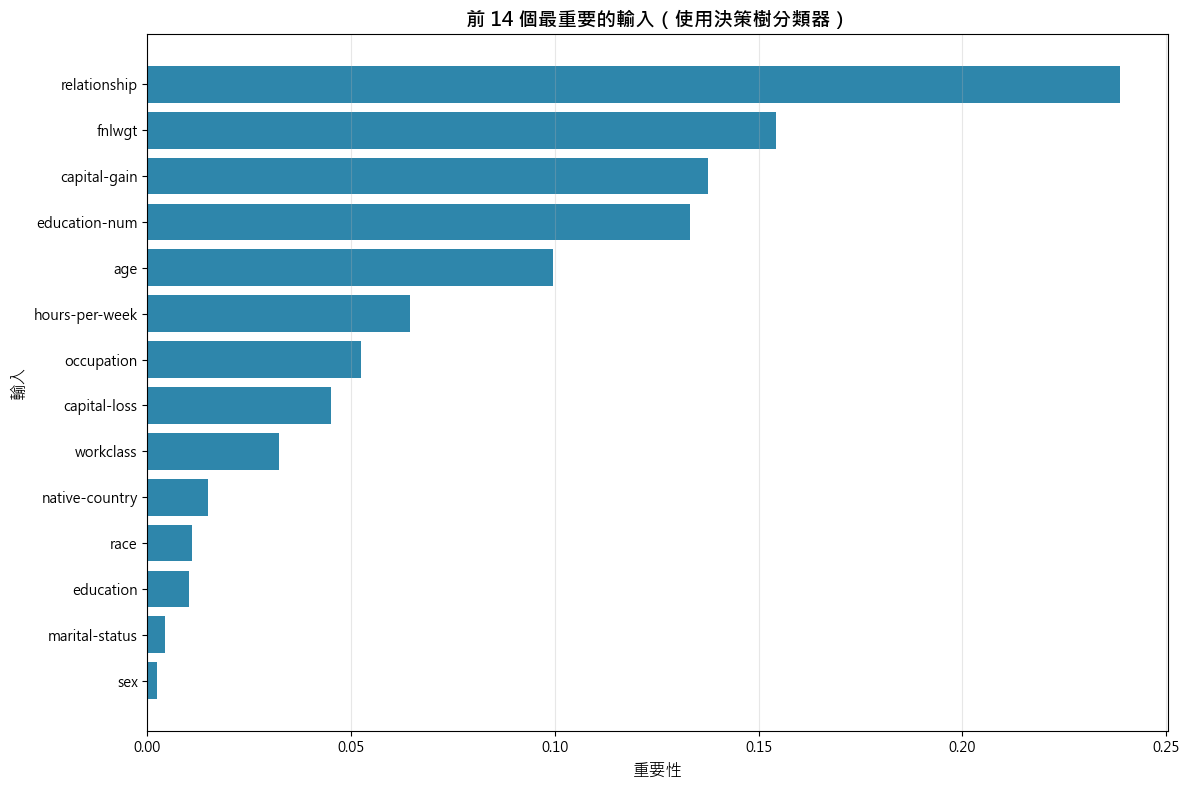

特徵重要性圖已存為 'feature_importance.png'


In [31]:
# 分析特徵重要性
print("特徵重要性分析結果：")
print("使用 CART 模型（模型 2 - 中等剪枝）分析特徵重要性")

feature_importance = pd.DataFrame({
    # '特徵': X.columns,
    '特徵': train_X.columns,
    '重要性': model_2.feature_importances_
}).sort_values('重要性', ascending=False)

print("前 20 個最重要的輸入：")
print(feature_importance.head(20).to_string(index=False))

# 繪製特徵重要性圖
plt.figure(figsize=(12, 8))
# 動態調整 top_n，避免超過實際特徵數量
top_n = min(20, len(feature_importance))  # 取較小值
top_features = feature_importance.head(top_n)
plt.barh(range(len(top_features)), top_features['重要性'].values, color='#2E86AB')
plt.yticks(range(len(top_features)), top_features['特徵'].values)
plt.xlabel('重要性', fontsize=12)
plt.ylabel('輸入', fontsize=12)
plt.title(f'前 {len(top_features)} 個最重要的輸入（使用決策樹分類器）', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("特徵重要性圖已存為 'feature_importance.png'")


## 10. 參考資料

### 決策樹演算法
- [Scikit-learn Decision Trees Documentation](https://scikit-learn.org/stable/modules/tree.html)

### 資料集
- [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/adult)